# Data exploration: $\eta\pi$ from COMPASS

In [ ]:
using InstantiateFromURL
github_project("mmikhasenko/Introduction2AmplitudeAnalysis")

In [249]:
using UpROOT # reading ROOT files
using Parameters # pack, unpack
using TypedTables # 
using StaticArrays # fixed size arrays
using Plots # plotting
using LinearAlgebra # norm for a vector
using DelimitedFiles # read and write tabled data

In [250]:
theme(:wong, bottom_margin=3Plots.PlotMeasures.mm) # colors of the plots

In [259]:
@with_kw mutable struct Particle
    E::Float64
    p::MVector{3,Float64}
end
Particle(E,px,py,pz) = Particle(E=E, p=SVector(px,py,pz))
Particle(px,py,pz; msq=error("mass needed")) = Particle(E=sqrt(px^2+py^2+pz^2+msq), p=SVector(px,py,pz))

# properties
invmasssq(p::Particle) = p.E^2-sum(abs2,p.p)
mass(p::Particle) = sqrt(invmasssq(p))
# 
import Base:+,-,*,show
+(p1::Particle, p2::Particle) = Particle(E=p1.E+p2.E, p=p1.p+p2.p)
*(p::Particle, α::T where T<:Real) = Particle(E=p.E*α, p=p.p*α)
*(α::T where T<:Real, p::Particle) = Particle(E=p.E*α, p=p.p*α)
-(p1::Particle, p2::Particle) = p1+(-1)*p2
# 
show(io::IO, p::Particle) = print(io, "P($(p.E),$(p.p))")

# transformations
function Ry!(p,θ)
    sinθ, cosθ = sin(θ), cos(θ)
    p.p[1], p.p[3] =  p.p[1]*cosθ+sinθ*p.p[3],
                     -p.p[1]*sinθ+cosθ*p.p[3]
end
function Rz!(p,ϕ)
    sinϕ, cosϕ = sin(ϕ), cos(ϕ)
    p.p[1], p.p[2] = p.p[1]*cosϕ-sinϕ*p.p[2],
                     p.p[1]*sinϕ+cosϕ*p.p[2]
end
function Bz!(p,γ)
    _γ = abs(γ)
    _βγ = sqrt(γ^2-1)*sign(γ)
    p.p[3], p.E = _γ *p.p[3]+_βγ*p.E,
                  _βγ*p.p[3]+ _γ*p.E
end

Bz! (generic function with 1 method)

In [269]:
f = TFile(joinpath("data","pi03pic_mc_pwa_model_2.root"))
t = f["pi03pic"][:];

In [270]:
propertynames(t)

(:pBeamE, :pBeamY, :pRecoilY, :pPimX, :pBeamX, :pRecoilE, :pEtaX, :pEtaY, :pPimY, :pPimE, :pEtaZ, :pEtaE, :pRecoilZ, :pPimZ, :pRecoilX, :pBeamZ)

## Masses of the particles

In [263]:
process(row) = 
   (pb = Particle(row.pBeamE,   row.pBeamX,   row.pBeamY,   row.pBeamZ),
    pr = Particle(row.pRecoilE, row.pRecoilX, row.pRecoilY, row.pRecoilZ),
    pπ = Particle(row.pPimE,    row.pPimX,    row.pPimY,    row.pPimZ),
    pη = Particle(row.pEtaE,    row.pEtaX,    row.pEtaY,    row.pEtaZ))

process (generic function with 1 method)

In [264]:
fv = Table(process.(t)); # create the four vectors

## Presentation of the data

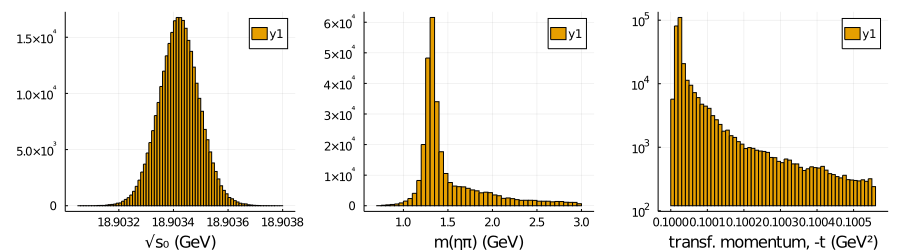

In [267]:
plot(layout=grid(1,3), size=(900,250),
    histogram(mass.(fv.pπ+fv.pη+fv.pr), bins=100, xlab="√s₀ (GeV)"),
    histogram(mass.(fv.pπ+fv.pη), xlab="m(ηπ) (GeV)", bins=100),
    histogram(-invmasssq.(fv.pb-fv.pη-fv.pπ), xlab="transf. momentum, -t (GeV²)", bins=100, yscale=:log10)
)

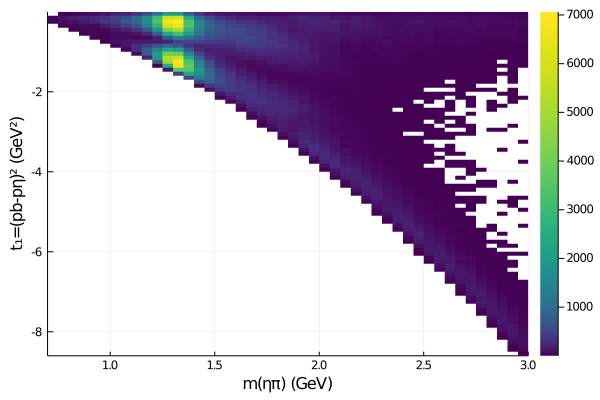

In [224]:
histogram2d(mass.(fv.pπ+fv.pη),
            invmasssq.(fv.pb-fv.pη), xlab="m(ηπ) (GeV)", ylab="t₁=(pb-pη)² (GeV²)",
    color=cgrad(:viridis, scale=:exp))

In [225]:
angles(p::Particle) = p.p[3]/norm(p.p), atan(p.p[2],p.p[1])
boostzfactor(p::Particle) = p.E/mass(p)

boostzfactor (generic function with 1 method)

In [226]:
@recipe function f(p::Particle, proj=:zx)
    arrow   := true
    linewidth  :=  2
    tip = (p.p[3],p.p[1])
    tip = (proj == :xy) ? (p.p[1],p.p[2]) : tip
    return [(0,0), tip]
end

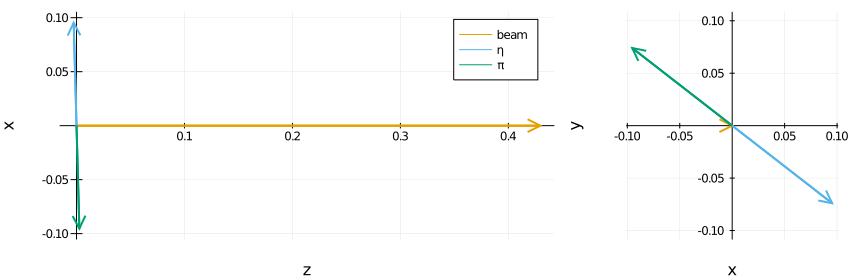

In [240]:
@unpack pb, pη, pπ, pr = fv[6]
cosθ,ϕ = angles(pπ+pη)
γ = boostzfactor(pπ+pη)
#
Rz!.([pb, pη, pπ, pr], -ϕ)
Ry!.([pb, pη, pπ, pr], -acos(cosθ))
Bz!.([pb, pη, pπ, pr], -γ)
# #
cosθ,ϕ = angles(pb)
Rz!.([pb, pη, pπ, pr], -ϕ)
Ry!.([pb, pη, pπ, pr], -acos(cosθ))
# # 
cosθ,ϕ = angles(pr)
Rz!.([pb, pη, pπ, pr], π-ϕ)
let
    plot(layout=grid(1,2, widths=(0.7,0.3)), aspect_ratio=1, size=(850,280), frame=:origin)
    plot!(sp=1, xlab="z", ylab="x");    plot!(sp=2, xlab="x", ylab="y")
    plot!(sp=1, pb, :zx, lab="beam");   plot!(sp=2, pb, :xy, lab="")
    plot!(sp=1, pη, :zx, lab="η");      plot!(sp=2, pη, :xy, lab="")
    plot!(sp=1, pπ, :zx, lab="π");      plot!(sp=2, pπ, :xy, lab="")
#     plot!(sp=1, pr, :zx, lab="recoil"); plot!(sp=2, pr, :xy, lab="")
end

In [228]:
function anglesGJ!(;pb, pη, pπ, pr)
    pb, pη, pπ, pr
    cosθ,ϕ = angles(pπ+pη)
    γ = boostzfactor(pπ+pη)
    #
    Rz!.([pb, pη, pπ, pr], -ϕ)
    Ry!.([pb, pη, pπ, pr], -acos(cosθ))
    Bz!.([pb, pη, pπ, pr], -γ)
    # #
    cosθ,ϕ = angles(pb)
    Rz!.([pb, pη, pπ, pr], -ϕ)
    Ry!.([pb, pη, pπ, pr], -acos(cosθ))
    # # 
    cosθ,ϕ = angles(pr)
    Rz!.([pb, pη, pπ, pr], π-ϕ)
    return angles(pη)
end

anglesGJ! (generic function with 1 method)

In [229]:
kinvars = Table([NamedTuple{(:cosθ,:ϕ,:mηπ)}([anglesGJ!(;v...)...,mass(v.pη+v.pπ)]) for v in fv])

Table with 3 columns and 301509 rows:
      cosθ        ϕ          mηπ
    ┌────────────────────────────────
 1  │ 0.195056    0.844116   0.746092
 2  │ -0.377158   1.44063    0.746093
 3  │ 0.124863    2.60888    0.749001
 4  │ -0.301097   1.7275     0.747063
 5  │ 0.321269    2.24002    0.743173
 6  │ -0.0218408  -0.660148  0.740242
 7  │ -0.701538   0.470193   0.738281
 8  │ -0.845097   1.08823    0.747063
 9  │ -0.235953   1.66328    0.742196
 10 │ 0.188018    0.755586   0.742685
 11 │ 0.0750287   -2.1202    0.740242
 12 │ 0.209545    0.783272   0.742196
 13 │ 0.298567    -1.11891   0.742197
 14 │ -0.316157   -1.76627   0.740241
 15 │ 0.471116    2.48357    0.743172
 16 │ -0.67887    2.67181    0.743173
 17 │ -0.0153329  1.98629    0.74122
 18 │ -0.72464    -1.12899   0.740242
 19 │ -0.804498   -1.30071   0.738281
 20 │ 0.0726688   0.985721   0.743173
 21 │ 0.542215    -1.94304   0.742197
 22 │ -0.398314   0.848841   0.744147
 23 │ -0.202187   0.548641   0.747063
 ⋮  │     ⋮       

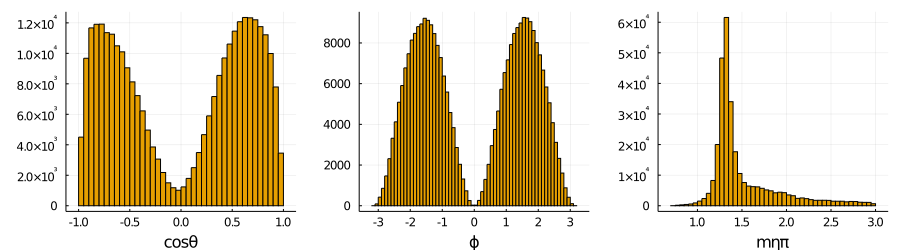

In [241]:
plot(layout=grid(1,3), size=(900,250),
    histogram(kinvars.cosθ, lab="", xlab="cosθ"),
    histogram(kinvars.ϕ, lab="", xlab="ϕ"),
    histogram(kinvars.mηπ, lab="", xlab="mηπ", bins=100)
)

## Explore how the angular dependence changes with mass

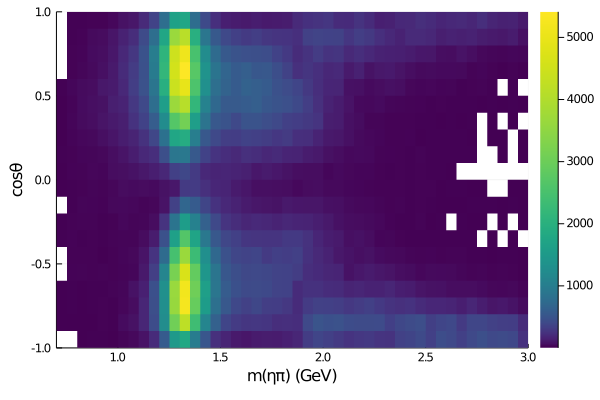

In [242]:
histogram2d(kinvars.mηπ, kinvars.cosθ, xlab="m(ηπ) (GeV)", ylab="cosθ",
        color=cgrad(:viridis, scale=:exp))

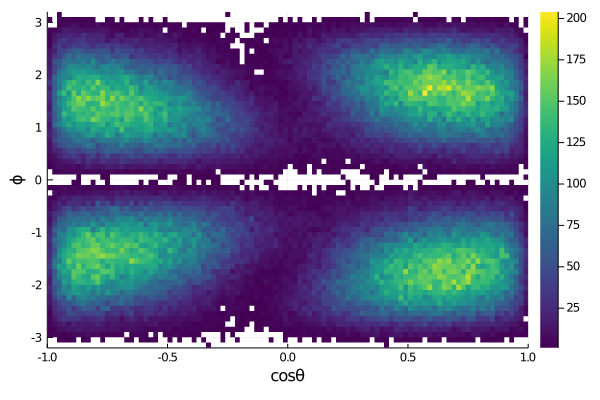

In [244]:
histogram2d(kinvars.cosθ, kinvars.ϕ, xlab="cosθ", ylab="ϕ", bins=100)

In [247]:
writedlm(joinpath("data","data_metapi_costheta_phi.txt"), [kinvars.mηπ kinvars.cosθ kinvars.ϕ])